# STATS 542: Homework 4

<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Tuesday 11:59 PM CT, Mar 2nd </center></h4>

## About HW4

This HW contains two major parts. In the first part, we will try to understand the properties of Ridge regression under a case where variables are highly correlated. In the first part, we perform an one-variable Lasso problem using the formula developed in the lecture. This one-variable Lasso code will then be used in HW5 to solve the solution of Lasso in a coordinate descent algorithm. 


## Question 1 [40 Points] Correlated Variables in Ridge

For this question, we will use the same [Bitcoin data](https://teazrq.github.io/stat542/data/bitcoin.csv) we already constructed in HW3. Use the same training and testing data construction. You may have already noticed that if a linear model is used to perform that task, some parameters cannot be properly estimated, for example, the `n_transactions_total` parameter is only estimated on day 1, while for day 2 and 3, their parameter estimates are `NA` because they are both highly linearly dependent on day 1. Co-linearity is a severe problem of linear regression but Ridge regression can be used to solve that problem. 

### [20 Points] A Simulation Study

For this sub-question you must **write your own code** without using loading any additional package, but you can still use the `lm()` function from the base package. Construct your data in the following way

$$ Y = X_1 \times 0.7 + X_2 \times 0.8 + X_3 \times 0.9 + \epsilon $$
where $X_1$ and $\epsilon$ are generated independently from standard normal distribution, and the other two covariates are simply copies of $X_1$, meaning that $X_2 = X_3 = X_1$. Generate 100 samples from this model, make sure that you save a random seed. You should write your down code to implement the ridge regression, and **no intercept is needed**. Answer the following questions before you actually fit the models:

  * What will happen (regarding the parameter estimates) when you fit a linear regression using data from this model? And why?


**Answer:**

Trying to fit a linear regression using OLS would result in a singular $X^TX$ matrix because its columns are linearly dependent (they are all equal). Since this matrix is not invertible, we cannot compute $\hat\beta=(X^TX)^{-1}X^Ty$.

Even if the columns were slightly different (but still highly correlated), we would have issues because the coefficients could have very high absolute values. This would be result in a model with high variance. This is because two highly correlated variables can carry large coefficients with opposite signs and offset each other.

  * Will Ridge regression be able to address this problem? Will the parameters of the three variables be different or the same?
 

**Answer**:

Yes, with ridge regression this issue would be solved. The parameter estimates should all be the same because we are penalizing the sum of their squares and the minimum would be reached when all the coefficients are the same. Note that it does not matter that the coefficients are different in our ground-truth model for $Y$ because all the covariates carry the exact same information.

 * Using the singular value decomposition (SVD) and shrinkage understanding we developed during the lecture to explain why you would expect such results from the ridge regression. 

**Answer**:

Fitting the ridge regression is analogous to performing principal component analysis on the data and shrinking the coefficients for the low variance components in comparison to the high variance component. Since the data is perfectly collinear in this case (given $X_2 = X_3 = X_1$) all of the variance is accounted by the principal component. Therefore, the first eigenvalue will be relatively high and the remaining ones will be (virtually) zero. The principal direction is a linear combination of the three coordinates spanning the vector space of the data where all the linear coefficients are the same due to the perfect collinearity of the data. In other words, the principal direction is formed by mixing the three existing coordinates in "equal parts" which helps explain why all elements of $\hat\beta_{ridge}$ are the same.

Now, use your generated data to confirm your statements. You do no need to tune the penalty term $\lambda$, just fix it at any nonzero value. Display sufficient information to support your statements, this includes the eigen-values and the rotation matrix $\mathbf{V}$ from the SVD of $X$. 

After preforming the above, modify your data by multiplying your $X_1$ by 2. Then use your code to fit the ridge regression again. What changes do you observe? Are the fitted value $\hat y$ changing? 

In [1]:
seed = 1

In [2]:
import numpy as np # Needed because Python does not have native vector object

In [3]:
def fit_ridge_regression(X, y, l=1, seed=None):
    '''
    Fit ridge regression with design matrix X (no intercept), output y, and lambda l (defaults to 1).
    If seed is given, the numpy random seed will be set to that value.
    
    Returns beta_hat (fit parameters).
    '''
    if seed:
        np.random.seed(seed)
    
    M = np.matmul(X.T, X)
    
    assert(M.shape[0] == M.shape[1]) # M should be square
    size = M.shape[0]
    
    I = np.identity(size)
    
    M_inv = np.linalg.inv(M + l*I)
    
    return np.matmul(np.matmul(M_inv, X.T), y)

In [4]:
# Construct data
np.random.seed(seed)

X1 = np.random.normal(size=100) # 100 samples from standard normal distribution
X2 = X1
X3 = X1

X = np.empty((100, 3))
X[:,0] = X1
X[:, 1] = X2
X[:, 2] = X3

epsilon = np.random.normal(size=100)

y = 0.7*X1+0.8*X2+0.9*X3 + epsilon

In [5]:
#Fit ridge regression
beta_hat = fit_ridge_regression(X, y, seed=seed)

In [6]:
print(beta_hat)

[0.83205716 0.83205716 0.83205716]


**Answer:**
we obtained equal coefficients as I was expecting.

Looking at the eigenvalues of $X^TX$:

In [7]:
eigenvalues, eigenvectors = np.linalg.eig(np.matmul(X.T, X))
print(eigenvalues)

[ 2.36151541e+02 -2.32062286e-14  1.51939595e-31]


**Answer:**
we obtained one large eigenvalue and all the other eigenvalues are nearly zero, as explained above.

In [8]:
U, D, V = np.linalg.svd(np.matmul(X.T, X)) 
print(V.T)

[[-0.57735027 -0.81649658 -0.        ]
 [-0.57735027  0.40824829  0.70710678]
 [-0.57735027  0.40824829 -0.70710678]]


**Answer:**
we can see that in the matrix $V$ we have a first principal direction, (-0.57735027, -0.57735027, -0.57735027), that has exactly equal coefficients for all coordinates (e.g., the coordinates are "mixed in equal parts"). This also aligns with what I said above.

Now let us multiply $X_1$ by $2$ and repeat the simulation.

In [9]:
X = np.empty((100, 3))
X[:,0] = X1*2
X[:, 1] = X2
X[:, 2] = X3

y = 0.7*X1+0.8*X2+0.9*X3 + epsilon

In [10]:
beta_hat_2 = fit_ridge_regression(X, y, seed=seed)

In [11]:
print(beta_hat_2)

[0.83381514 0.41690757 0.41690757]


In [12]:
eigenvalues, eigenvectors = np.linalg.eig(np.matmul(X.T, X))
print(eigenvalues)

[ 4.72303083e+02 -5.32094041e-14  1.02728448e-30]


In [13]:
U, D, V = np.linalg.svd(np.matmul(X.T, X)) 
print(V.T)

[[-0.81649658 -0.57735027 -0.        ]
 [-0.40824829  0.57735027  0.70710678]
 [-0.40824829  0.57735027 -0.70710678]]


**Answer:**
we can appreciate that the parameter for the doubled covariate is now double the coefficients of the other two covariates. When looking at the matrix $V$ we can see that the reason is that the principal direction now points more towards the first coordinate, as shown by the highest coefficient (in absolute value) in the first column of $V$.

### [20 Points] Bitcoin Price Prediction Revisited

For this question, take the same training and testing split from the Bitcoin data, and fit a ridge regression. You can use any existing package to perform this.

  * State what criteria is used to select the best $\lambda$.
  
**Answer:** I am using leave-one-out cross validation to select the best lambda.

  * State what values of $\lambda$ are considered.
  
**Answer:** I am considering these values: [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10].

  * Compare your model fitting results with the linear model in terms of their performances on the testing data.
  
**Answer:** see errors at the end of the question.

In [14]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [15]:
def preprocess_data(csv_file):
    '''
    Process bitcoin data the same way I did for HW3, Q2.1
    '''
    
    bitcoin_raw_data = pd.read_csv(csv_file) # Load data
    bitcoin_raw_data.Date = pd.to_datetime(bitcoin_raw_data.Date) # Convert to datetime format
    
    # Split test and train data
    bitcoin_raw_train = bitcoin_raw_data[bitcoin_raw_data.Date <= '2016-12-31'] # Before or on 12/31/2016
    bitcoin_raw_test = bitcoin_raw_data[bitcoin_raw_data.Date >= '2017-01-01'] # On or after 01/01/2017
    bitcoin_raw_test = bitcoin_raw_test.reset_index(drop=True) # Make sure index starts at zero
    
    # Get new (unique) column names for each column in design matrix
    temp = bitcoin_raw_train.loc[:2, bitcoin_raw_train.columns != 'Date']
    temp.index = temp.index + 1
    temp2 = temp.stack()
    temp2.index = temp2.index.map('{0[1]}_{0[0]}'.format)
    new_column_names = temp2.to_frame().T.columns.to_list()
    
    # Convert to numpy to rearrange data
    bitcoin_raw_train_numpy = bitcoin_raw_train.to_numpy()
    bitcoin_raw_test_numpy = bitcoin_raw_test.to_numpy()

    # Drop "Date" column (they are ordered by index anyway)
    bitcoin_raw_train_numpy = bitcoin_raw_train_numpy[:, 1:]
    bitcoin_raw_test_numpy = bitcoin_raw_test_numpy[:, 1:]

    # Build training dataset
    N = bitcoin_raw_train.shape[0]
    train_set = np.empty((N-6, 69)) # N-6 samples and 69 columns
    train_outcomes = np.empty((N-6))
    for n in range(N-6):
        row = bitcoin_raw_train_numpy[n:n+3].reshape(1, 69)
        train_set[n, :] = row
        train_outcomes[n] = bitcoin_raw_train_numpy[n+6, 0]

    # Build testing dataset
    N = bitcoin_raw_test.shape[0]
    test_set = np.empty((N-6, 69)) # N-5 samples and 69 columns
    test_outcomes = np.empty((N-6))
    for n in range(N-6):
        row = bitcoin_raw_test_numpy[n:n+3].reshape(1, 69)
        test_set[n, :] = row
        test_outcomes[n] = bitcoin_raw_test_numpy[n+6, 0]
    
    # Convert back to pandas dataframes
    train_set = pd.DataFrame(np.append(train_set, train_outcomes.reshape(train_outcomes.shape[0], 1), axis=1), columns=new_column_names + ['outcome'])
    test_set = pd.DataFrame(np.append(test_set, test_outcomes.reshape(test_outcomes.shape[0], 1), axis=1), columns=new_column_names + ['outcome'])
    
    # Drop any potential null (N/A) values
    train_set = train_set.dropna()
    test_set = test_set.dropna()
    
    # Scale data
    scaler = RobustScaler().fit(train_set)
    train_set = scaler.transform(train_set)
    test_set = scaler.transform(test_set)
    
    return train_set, test_set

In [16]:
train_set, test_set = preprocess_data('bitcoin.csv')

In [17]:
X_train = train_set[:, :-1]
y_train = train_set[:, -1]

X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [18]:
l = np.asarray([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]) # Values of lambda that are considered
ridge = RidgeCV(alphas=l, store_cv_values=True).fit(X_train, y_train)

In [19]:
ridge.alpha_

0.1

**Answer:** the best model used $\lambda = 0.1$

In [20]:
# Scoring the model against test data
y_hat = ridge.predict(X_test)
MSE = mean_squared_error(y_test, y_hat)

In [21]:
print("Ridge regression test MSE:", MSE)

Ridge regression test MSE: 6.340686826122607


Recalling the error from my OLS model from HW3 (backward selection with BIC):

`MSE backward test error: 5.6939683521808355`

**Answer:** since the test error is higher for the ridge model, we can conclude that OLS model performs better. This is probably due to the introduction of bias in ridge regression, which is too high to offset the reduction in variance we are gaining here. Since the OLS is the BLUE, there is no bias introduced in that model. We also have to consider that I used different model selection criteria to get the models I'm comparing: I used backward selection (with BIC) to select the best features in the OLS model, but I used leave-one-out CV to pick the best $\lambda$ for ridge regression, so this might have also impacted the performance of ridge regression.

## Question 2 [60 Points] One Variable Lasso

Based on our development in the lecture, fitting a one variable Lasso is simply a soft-thresholding problem. Use the following code the generate a normalized data (if you use python, then do `import random` and call `random.seed(1)`) :

```r
  set.seed(1)
  n = 100
  X = rnorm(n)
  X = X / sqrt(sum(X*X))
  Y = X + rnorm(n)
```

Please be aware that instead of $\mathbf{X}^T \mathbf{X} = \mathbf{I}$ in the lecture note, we have $\mathbf{X}^T \mathbf{X} = n \mathbf{I}$. However, the derivation in page 33, 34 and 35 from the lecture notes remains largely unchanged except some scaling issues. We will derive a new result using the following objective function for this question:

$$\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

In [22]:
np.random.seed(seed)
n = 100
X = np.random.normal(size=n)
X = X / np.sqrt(np.sum(X*X))
Y = X + np.random.normal(size=n)

### [30 Points] The Soft-thresholding Function

Consider a model **without intercept**. Perform the rest:

  * Re-derive the ${\hat \beta}^{\text Lasso}$ formula in page 34 and 35 based on this one variable Lasso problem with $\mathbf{X}^T \mathbf{X} = \mathbf{I}$. What is the difference between this and the original one? 
  * After you obtaining the soft-thresholding solution similar to page 35, write a function in the form of `soft_th <- function(b, lambda)` to calculate it, where `b` is the OLS estimator, and $\lambda$ is the penalty level.
  * Apply this function to your data and obtain the Lasso solution. Report your results


Here I will derive the result for $\hat\beta^{Lasso}$ for the case $X^TX=nI$ with the objective function

$$\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$



Derivation:
$$\hat\beta^{Lasso}=\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

$$\hat\beta^{Lasso}=\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\hat\beta^{OLS} \rVert^2 + \lVert \mathbf{X}\hat\beta^{OLS} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

$$\hat\beta^{Lasso}=\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{X}\hat\beta^{OLS} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

$$\hat\beta^{Lasso}=\arg\min_{\beta} \frac{1}{2n} (\hat\beta^{OLS} - \beta)^T \mathbf{X}^T \mathbf{X} (\hat\beta^{OLS} - \beta) + \lambda \lVert \beta \rVert_1$$

$$\hat\beta^{Lasso}=\arg\min_{\beta} \frac{1}{2} (\hat\beta^{OLS} - \beta)^T (\hat\beta^{OLS} - \beta) + \lambda \lVert \beta \rVert_1$$

$$\hat\beta^{Lasso}_j=\arg\min_{\beta_j} \frac{1}{2}  (\hat\beta^{OLS}_j - \beta_j)^2 + \lambda \lVert \beta_j \rVert_1$$

$$\hat\beta^{Lasso}_j=
\begin{cases}
      \hat\beta^{OLS}_j - \lambda & \hat\beta^{OLS}_j > \lambda\\
      0 & \vert{\hat\beta^{OLS}_j}\vert \le \lambda\\
      \hat\beta^{OLS}_j + \lambda & \hat\beta^{OLS}_j < -\lambda\\
    \end{cases}$$

The difference between this solution and the one from slide 35 is that the lambda parameter is not scaled by $\frac{1}{2}$. This is the result of adding the $\frac{1}{2}$ scaling factor in the objective function. We can also observe that although we had $X^TX=nI$, there is no $n$ factor in the solution because it was taken care of in the objective function. 

In [23]:
def soft_th(b, l):
    '''
    Return the Lasso regression fit parameters from the corresponding OLS parameters (b) and penalty constant (l).
    '''
    assert(l > 0) # lambda must be greater than zero
    
    size = b.shape[0]
    b_lasso = np.empty(size)
    
    for j in range(size):
        if b[j] > l:
            b_lasso[j] = b[j] - l
        elif np.abs(b[j]) < l:
            b_lasso[j] = 0
        elif b[j] < -l:
            b_lasso[j] = b[j] + l
    
    return b_lasso

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False).fit(X.reshape(100, 1), Y)
b = model.coef_
OLS_error = mean_squared_error(Y, model.predict(X.reshape(100, 1)))
l_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10] # Lambda values I'm considering
size = len(l_values)
errors = np.empty(size)

for i in range(size):
    b_lasso = soft_th(b, l_values[i])
    Y_hat = np.matmul(X.reshape(100, 1), b_lasso)
    errors[i] = mean_squared_error(Y, Y_hat)

In [25]:
b_lasso_best = soft_th(b, l_values[errors.argmin()])

In [26]:
print("Best parameter:", b_lasso_best)
print("OLS parameter:", b)

Best parameter: [1.94704012]
OLS parameter: [1.94704112]


In [27]:
print("Lasso MSE (best model):", errors[errors.argmin()])
print("OLS MSE:", OLS_error)

Lasso MSE (best model): 0.8829917150395454
OLS MSE: 0.8829917150395354


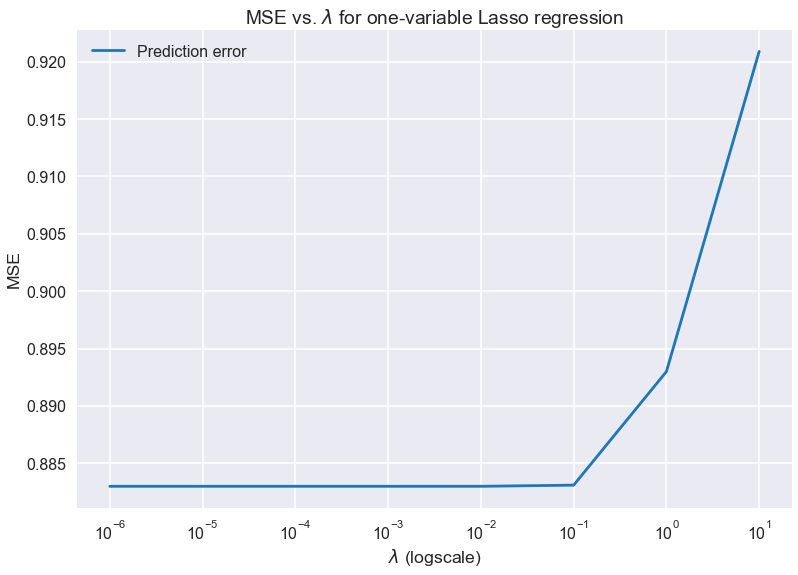

In [28]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')

plt.plot(l_values, errors)
plt.title("MSE vs. $\lambda$ for one-variable Lasso regression")
plt.legend(["Prediction error"])
plt.xlabel("$\lambda$ (logscale)")
plt.ylabel("MSE")
plt.xscale('log')
plt.show()
plt.close()

We can conclude that applying the penalization resulted in a slightly lower parameter for this one-variable regression. However, the error did not decrease when using Lasso instead of OLS. This might be caused by the bias term in Lasso. In terms of the optimal $\lambda$ value, it is clear from the plot that any value lower than $10^{-1}$ achieved the same result (the MSEs are the same). For $\lambda=10$, the parameter was zero.

### [30 Points] The Intercept, centering and Scaling Issue

Re-generate your data based on the following code:

```r
  set.seed(1)
  n = 100
  X = rnorm(n, mean = 1, sd = 2)
  Y = 1 + X + rnorm(n)
```

For this question, we will use a technique to deal with the center and scale of $X$ based on the following intuition: 

$$
\begin{align}
\frac{Y - \bar{Y}}{\text{sd}_y} =&~ \sum_{j=1}^p \frac{X_j - \bar{X}_j}{\text{sd}_j} \gamma_j \\
Y =&~ \underbrace{\bar{Y} - \sum_{j=1}^p \bar{X}_j \frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_0} + \sum_{j=1}^p X_j \underbrace{\frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_j},
\end{align}
$$

A common practice when dealing with the intercept and scaling is to perform the following:

  * Center and scale both $\mathbf{X}$ (column-wise) and $\mathbf{y}$ and denote the processed data as $\frac{Y - \bar{Y}}{\text{sd}_y}$ and $\frac{X_j - \bar{X}_j}{\text{sd}_j}$ in the above formula.
  * Fit a linear regression (or Lasso) using the processed data based on the no-intercept model, and obtain the parameter estimates $\gamma_j$. In our case, there is only 1 $j$. 
  * Recover the original parameters $\beta_0$ and $\beta_j$'s. 
  
Understand and implement this procedure to our one-variable Lasso problem and obtain the Lasso solution on the original scale. You must write your own code and use the `soft_th()` function previously defined.

In [29]:
np.random.seed(seed)
n = 100
X = np.random.normal(loc=1, scale=2, size=n)
Y = 1 + X + np.random.normal(size=n)

In [30]:
def scale_data(X, Y):
    '''
    Standardize data and predictions (center on mean = 0 and scale to stadard deviation = 1).
    Returns stadardized data (X_std, Y_std) and necessary parameters (mu_j, sd_j, mu_y, sd_y) 
    to recover the predictions in the original scale.
    '''
    mu_j = np.mean(X, axis=0)
    sd_j = np.std(X, axis=0)
    mu_y = np.mean(Y, axis=0)
    sd_y = np.std(Y, axis=0)
   
    X_std = (X - mu_j) / sd_j
    Y_std = (Y - mu_y) / sd_y
    
    return X_std, Y_std, mu_j, sd_j, mu_y, sd_y

In [31]:
X_std, Y_std, mu_j, sd_j, mu_y, sd_y = scale_data(X.reshape(100, 1), Y)

model = LinearRegression(fit_intercept=False).fit(X_std, Y_std)
b = model.coef_
OLS_error = mean_squared_error(Y_std, model.predict(X_std))
l_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10] # Lambda values I'm considering
size = len(l_values)
errors = np.empty(size)
b_0 = np.empty(size)
b_1 = np.empty(size)

for i in range(size):
    b_lasso = soft_th(b, l_values[i])
    Y_hat = np.matmul(X_std, b_lasso)
    errors[i] = mean_squared_error(Y_std, Y_hat)
    b_0[i] = mu_y - mu_j*(b_lasso*sd_y)/sd_j
    b_1[i] = (sd_j*b_lasso)/sd_j

In [32]:
b_0_best = b_0[errors.argmin()]
b_1_best = b_1[errors.argmin()]

In [33]:
print("Best parameters (recovered to the original scale):")
print("b_0:", b_0_best)
print("b_1:", b_1_best)

Best parameters (recovered to the original scale):
b_0: 1.0993012764008838
b_1: 0.894277827036777


In [34]:
print("Lasso MSE (best model, scaled dimension):", errors[errors.argmin()])
print("OLS MSE (scaled dimension):", OLS_error)

Lasso MSE (best model, scaled dimension): 0.20026537951472662
OLS MSE (scaled dimension): 0.20026537951372667


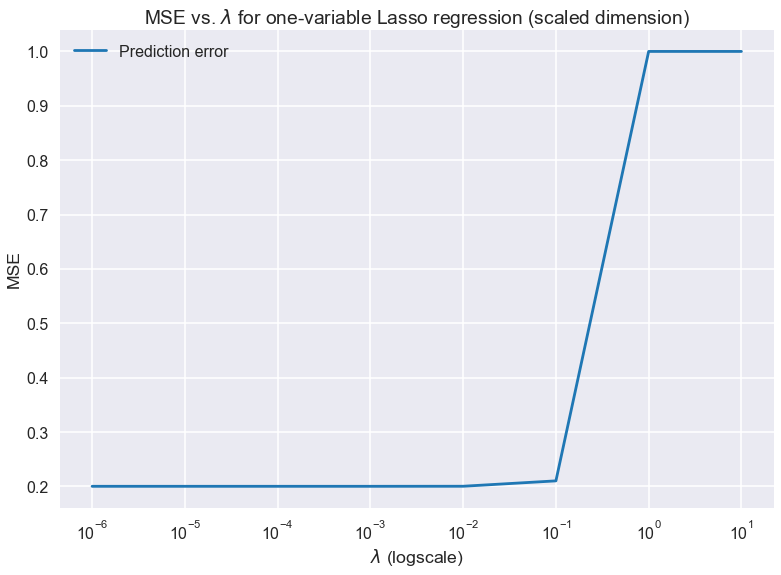

In [35]:
plt.plot(l_values, errors)
plt.title("MSE vs. $\lambda$ for one-variable Lasso regression (scaled dimension)")
plt.legend(["Prediction error"])
plt.xlabel("$\lambda$ (logscale)")
plt.ylabel("MSE")
plt.xscale('log')
plt.show()
plt.close()

In conclusion, we were able to recover the parameters in the original scale. We can appreciate that the intercept term, $\beta_0 = 1$ corresponds to the mean of the distribution we used to generate our data. 

Looking at the error, we can conclude (similarly to the previous subquestion) that applying the penalization did not result in a smaller error. This is probably because the Lasso regression is a biased estimator and we are computing the error on the training data, where the unbiased estimator will perform better even when overfitting occurs. 

In terms of the optimal $\lambda$ value for the regularization, we can observe in the plot that any value lower than $10^{-2}$ achieved the same result (the MSEs are the same). For $\lambda=1,10$ the parameter (scaled dimension) was zero.